# Sentiment analysis

Author: **Rafael Ito**  
e-mail: ito.rafael@gmail.com

## 0. Dataset and Description

**Name:**  IMDb  
**Description:** this notebook uses the IMDb dataset which contains movie reviews classified as either positive or negative review. The aim is to perform a supervised learning for sentiment classification using as features either TF-IDF representationr or word embeddings using GloVe.

## 1. Libraries and packages

### 1.1 Install packages

In [0]:
!pip install -q \
    numpy       \
    torch       \
    sklearn     \
    skorch      \
    matplotlib  

### 1.2 Import libraries

In [2]:
#-------------------------------------------------
# general
#-------------------
import numpy as np
import pandas as pd
import nltk
import re
#-------------------------------------------------
# PyTorch
#-------------------
import torch
from torch.utils.data import TensorDataset
from torchtext.vocab import GloVe
import torch.nn.functional as F
#-------------------------------------------------
# skorch
#-------------------
#from skorch import NeuralNetClassifier
#-------------------------------------------------
# scikit-learn
#-------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
#-------------------------------------------------
# data visualization
#-------------------
import matplotlib.pyplot as plt
import seaborn as sns
#-------------------------------------------------
# additional config
#-------------------
# random seed generator
torch.manual_seed(42);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1.3 Check device

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('Device:', device)

Device: cuda


### 1.4 Constants definition

In [0]:
# choose if the features to be used will be TF-IDF or word embeddings
TFIDF = True
#TFIDF = False
#-------------------
# define the size of embeddings (options: 50, 100, 200, 300)
EMBEDDING_DIM = 300

## 2. Custom functions and classes

### 2.1 Functions

Function that calculates the number of parameters of a network

In [0]:
'''
description:
    - given a model, this function returns its number of parameters (weight, bias)
#-------------------
positional args:
    - model [torch.nn.Module]: instance of the network
optional args:
    - verbose (default=False) [bool]: if True, print a report with the parameters of each layer
#-------------------
return:
    - [int] total parameters of the network
''';

In [0]:
def nparam(model, verbose=False):
    if(verbose):
        i = 0
        total = 0
        for name, param in model.named_parameters():
            if (param.requires_grad):
                #print('layer ', i, ' name: ', name)
                j = 1
                for dim in param.data.shape:
                    j = j * dim
                print('layer ', i, ': ', name, '; parameters: ', j, sep='')
                i += 1
                total += j
        print('total parameters = ', total)
        return
    else:
        #pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        return sum(p.numel() for p in model.parameters())

Function to plot confusion matrix

In [0]:
'''
description:
    - this function plots the confusion matrix (normalized or not) 
    using Matplotlib and seaborn in a nice way using heatmap.
#-------------------
positional args:
    - confusion_matrix  [numpy.ndarray]:    ex.: array([[88, 19],[22, 71]])
    - class_names       [list of str]:      ex.: ['negative', 'positive']

optional args:
    - title     (default=None)          [str]:      title of the plot
    - normalize (default=False)         [bool]:     values raw or normalized
    - cmap      (default=plt.cm.Blues)     \
       [matplotlib.colors.LinearSegmentedColormap]: colormap to be used
    - fig_size   (default=(10,7))        [tuple]:    size of the figure
    - fontsize  (default=14)            [int]:      size of the text
#-------------------
return:
  - fig [matplotlib.figure.Figure]: confusion matrix plotted in a nice way!
''';

In [0]:
#https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, title=None, normalize=False, cmap=plt.cm.Blues, figsize = (10,7), fontsize=14):
    # normalized or raw CM
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    #----------------------------
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt, cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    #----------------------------
    # fix matplotlib 3.1.1 bug
    #heatmap.get_ylim() --> (5.5, 0.5)
    #heatmap.set_ylim(6.0, 0)
    #----------------------------
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

Function that preprocess a document, returning the mean of word embeddings

In [0]:
'''
description:
    this function receives as parameter a document [str] and do the following:
      - convert to lower case,
      - split in tokens,
      - remove stop words
return:
    mean of the word embeddings of all tokens in the document
''';

In [0]:
def pre_processing(sentence, embedding=GloVe(name='6B', dim=300, cache='./glove_dir')):
    sentence = sentence.lower()                 # convert to lower case
    sentence = re.sub("[^\w]", " ",  sentence)  # match word characters [a-zA-Z0-9_]
    sentence = sentence.split()                 # split in tokens
    #---------------------------
    vectors = []
    is_first = True
    # remove stop words
    for token in sentence:
        if token not in stopwords: 
            if is_first:
                vectors = embedding[token].reshape(1,-1)
                is_first = False
            else:
                vectors = torch.cat((vectors, embedding[token].reshape(1,-1)), dim=0)
    return torch.mean(vectors, dim=0)

### 2.2 Classes

Class used for training in training loop

In [0]:
'''
description:
    this class is used during the training loop for TRAINING

parameters:
    - device
    - model
    - dataloader
    - loss_function
    - optimizer

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_train.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class TrainingLoop():
    def __init__(self, device, model, dataloader, loss_function, optimizer):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function
        self.optimizer = optimizer

    def __call__(self):
        # training mode
        self.model.train()
        loss_his = np.zeros(len(self.dataloader))
        score_train = 0.
        for b_i, (b_x, b_y) in enumerate(self.dataloader):   # for each training step
            b_x, b_y = b_x.to(self.device), b_y.to(self.device)
            y_logitos = self.model(b_x)
            loss = self.loss_function(y_logitos, b_y)
            self.optimizer.zero_grad()  # clear gradients for next train
            loss.backward()             # backpropagation, compute gradients
            self.optimizer.step()        # apply gradients
            #-------------------
            y_pred = torch.argmax(y_logitos, dim=1)
            score_train += (b_y == y_pred).sum()
            loss_his[b_i] = loss.item()
        return np.mean(loss_his), score_train.item()

Class used for validation in training loop

In [0]:
'''
description:
    this class is used during the training loop for VALIDATION

parameters:
    - device
    - model
    - dataloader
    - loss_function

return:
    np.mean(loss_his()) [numpy.float64]: mean of losses of all mini-batches in one epoch
    score_valid.item()  [float]:         accuracy calculated over one epoch  
''';

In [0]:
class ValidatingLoop():
    def __init__(self, device, model, dataloader, loss_function):
        self.device = device
        self.model = model
        self.dataloader = dataloader
        self.loss_function = loss_function

    def __call__(self):
        # evaluation mode
        self.model.eval()
        loss_his = np.zeros(len(self.dataloader))
        score_valid = 0.
        for b_ival, (b_xval, b_yval) in enumerate(self.dataloader):
            b_xval, b_yval = b_xval.to(self.device), b_yval.to(self.device)
            y_logitos = self.model(b_xval)
            loss_valid = self.loss_function(y_logitos, b_yval)
            yval_pred = torch.argmax(y_logitos, dim=1)
            score_valid += (b_yval == yval_pred).sum()
            loss_his[b_ival] = loss_valid.item()
        return np.mean(loss_his), score_valid

## 3. Dataset

### 3.1 Download dataset

In [15]:
# download dataset
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

File ‘imdb_sample.tgz’ already there; not retrieving.



### 3.2 Download embeddings

In [0]:
# !wget -nc http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -o glove.6B.zip -d glove_dir

Loading word embeddings with gensin

In [0]:
# import gensim.downloader as api

# word2vec_model = api.load("glove-wiki-gigaword-300")
# print(word2vec_model.vectors.shape)
# print(word2vec_model.index2word)

Loading word embeddings with torchtext

In [0]:
from torchtext.vocab import GloVe
glove_embedding = GloVe(name='6B', dim=EMBEDDING_DIM, cache='./glove_dir')

In [19]:
print(glove_embedding.vectors.shape)
print('First 20 words and its index:', list(glove_embedding.stoi.items())[:20])

torch.Size([400000, 300])
First 20 words and its index: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [20]:
glove_embedding['the'].shape

torch.Size([300])

### 3.3 Dataset preparation

In [0]:
# read csv spreadsheet
df = pd.read_csv('imdb_sample/texts.csv')

training-validation split

In [22]:
train = df[df['is_valid'] == False]
valid = df[df['is_valid'] == True]
#---------------------------
print('treino.shape:', train.shape)
print('valid.shape:', valid.shape)

treino.shape: (800, 3)
valid.shape: (200, 3)


Corpus

In [0]:
# use only training
corpus = train['text'].tolist()
# use training and validation
#corpus = df['text'].tolist()

In [24]:
# scikit-learn
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
vocab = vectorizer.get_feature_names()
#---------------------------
vocab_size = len(vocab)
print('vocab size:', vocab_size)

vocab size: 16461


Input

In [25]:
# slice pandas dataframe
X_train_pd = train['text']
X_valid_pd = valid['text']
#---------------------------
print(type(X_train_pd))

<class 'pandas.core.series.Series'>


TF-IDF

In [26]:
# transform using TF-IDF
X_train_sparse = vectorizer.transform(X_train_pd)
X_valid_sparse = vectorizer.transform(X_valid_pd)
#---------------------------
# convert from sparse matrix to tensor
X_train_tfidf = torch.tensor(X_train_sparse.toarray(), dtype=torch.float32)
X_valid_tfidf = torch.tensor(X_valid_sparse.toarray(), dtype=torch.float32)
#---------------------------
print('type of "X_train_sparse":', type(X_train_sparse))
print('type of "X_train":', type(X_train_tfidf))
print(X_train_tfidf.shape)

type of "X_train_sparse": <class 'scipy.sparse.csr.csr_matrix'>
type of "X_train": <class 'torch.Tensor'>
torch.Size([800, 16461])


Mean of embeddings

In [27]:
# convert from pandas to list
X_train_list = X_train_pd.tolist()
X_valid_list = X_valid_pd.tolist()
print(type(X_train_pd))
print(type(X_train_list))

<class 'pandas.core.series.Series'>
<class 'list'>


In [28]:
# get English stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
# print first 15 stop words
print(stopwords[:10])
# print number of stopwords
len(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


179

In [29]:
# converting list (str) in word embeddings
# training
X_train_emb = torch.zeros(len(X_train_list),glove_embedding.dim)
for i, document in enumerate(X_train_list):
    X_train_emb[i] = pre_processing(X_train_list[i], embedding=glove_embedding)
#---------------------------
# validation
X_valid_emb = torch.zeros(len(X_valid_list),glove_embedding.dim)
for i, document in enumerate(X_valid_list):
    X_valid_emb[i] = pre_processing(X_valid_list[i], embedding=glove_embedding)
#---------------------------
print(X_train_emb.shape)
print(X_valid_emb.shape)

torch.Size([800, 300])
torch.Size([200, 300])


Target

In [30]:
# get the label as string (either 'positive' or 'negative')
y_train_str = train['label']
y_valid_str = valid['label']
#---------------------------
# convert from string to boolean
mapping = {'positive': True, 'negative': False}
y_train_pd = y_train_str.map(mapping)
y_valid_pd = y_valid_str.map(mapping)
#---------------------------
print(y_train_str[:1].values)
print(y_train_pd[:1].values)

['negative']
[False]


In [31]:
# convert from pandas series to PyTorch
y_train = torch.LongTensor(y_train_pd.values)
y_valid = torch.LongTensor(y_valid_pd.values)
#---------------------------
print('type of "y_train_pd":', type(y_train_pd))
print('type of "y_train":', type(y_train))
print(y_train.shape)

type of "y_train_pd": <class 'pandas.core.series.Series'>
type of "y_train": <class 'torch.Tensor'>
torch.Size([800])


### 3.3 PyTorch dataset creation

In [0]:
if TFIDF:
    # datasets using TF-IDF
    ds_train = TensorDataset(X_train_tfidf, y_train)
    ds_valid = TensorDataset(X_valid_tfidf, y_valid)
else:
    # dataset using Word Embeddings
    ds_train = TensorDataset(X_train_emb, y_train)
    ds_valid = TensorDataset(X_valid_emb, y_valid)

### 3.4 PyTorch loader creation

- BATCH_SIZE definition
- training dataset
- validation dataset

In [0]:
BATCH_SIZE = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
            dataset=ds_train, 
            drop_last = False,
            shuffle = True,
            batch_size = BATCH_SIZE)
#-------------------------------------------------
# validation data loader
dl_valid =  torch.utils.data.DataLoader(
            dataset = ds_valid,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE)

### 3.5 Verifying shape, batch data type from loader and optionally its visualization

In [34]:
tx, ty = iter(dl_train).next()
print('train:', tx.shape, tx.dtype, ty.shape, ty.dtype)
tx, ty = iter(dl_valid).next()
print('val:', tx.shape, tx.dtype, ty.shape, ty.dtype)
print('last batch size:', len(ds_train)%BATCH_SIZE, len(ds_valid)%BATCH_SIZE)

train: torch.Size([100, 16461]) torch.float32 torch.Size([100]) torch.int64
val: torch.Size([100, 16461]) torch.float32 torch.Size([100]) torch.int64
last batch size: 0 0


## 4. Network Model

### 4.1 Network class definition

In [0]:
class NN(torch.nn.Module):
    def __init__(self, inputs, layer1_neurons, layer2_neurons):
        super(NN, self).__init__()
        self.inputs = inputs
        self.layer1_neurons = layer1_neurons
        self.layer2_neurons = layer2_neurons

        self.dropout = torch.nn.Dropout(0.5)
        self.layer1 = torch.nn.Linear(in_features=self.inputs,  out_features=self.layer1_neurons)
        self.layer2 = torch.nn.Linear(in_features=self.layer1_neurons,  out_features=self.layer2_neurons)
        self.layer3 = torch.nn.Linear(in_features=self.layer2_neurons,  out_features=2)

    def forward(self, x):
        #-------------------
        # dense layer, ReLU, dropout
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        #-------------------
        # dense layer, ReLU, dropout
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)
        #-------------------
        # dense layer
        x = self.layer3(x)
        #-------------------
        return x

### 4.2 Network instantiation

In [36]:
model = NN(inputs=vocab_size, layer1_neurons=600, layer2_neurons=100)
model.to(device)

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=16461, out_features=600, bias=True)
  (layer2): Linear(in_features=600, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=2, bias=True)
)

### 4.3 Network predict with few samples of batch from loader

In [37]:
model(ds_train[0][0].to(device))

tensor([-0.0331,  0.0758], device='cuda:0', grad_fn=<AddBackward0>)

## 5. Network training

### 5.1 Training definitions

- number of epochs
- optimizer and LR (learning rate)
- loss function


In [0]:
# Training parameters
EPOCH = 1000
LR = 0.05
PATIENCE = 20
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=LR)
#-------------------
best_valid_loss = 999_999.
train_samples = len(ds_train)
valid_samples = len(ds_valid)
#-------------------
trainer = TrainingLoop(device, model, dl_train, loss_func, opt)
validator = ValidatingLoop(device, model, dl_valid, loss_func)
#-------------------
# loss history
loss_train_his = []
loss_valid_his = []
acc_train_his = []
acc_valid_his = []

### 5.2 Training loop

In [39]:
for epoch in range(EPOCH):
    # training
    his_train = trainer()
    loss_train_his.append(his_train[0])
    acc_train_his.append(his_train[1] / train_samples)
    #-------------------
    # validating
    his_valid = validator()
    loss_valid_his.append(his_valid[0])
    acc_valid_his.append(his_valid[1] / valid_samples)
    #-------------------------------------------------
    # early stopping: check if new validation accuracy occurred
    if loss_valid_his[-1] < best_valid_loss:
        # print('New best loss in validation set!', end=' ')
        best_valid_loss = loss_valid_his[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter == PATIENCE:
            print('Early stopping:', PATIENCE, 'iterations without validation loss improve')
            break
    #-------------------------------------------------
    if not (epoch % 10):
        print('epoch =', epoch, end='; ')
        print('loss_train = {0:.4f}'.format(loss_train_his[-1]), end='; ')
        print('loss_val = {0:.4f}'.format(loss_valid_his[-1]), end='; ')
        print('acc_train = {0:.4f}'.format(acc_train_his[-1]), end='; ')
        print('acc_val = {0:.4f}'.format(acc_valid_his[-1]), end='\n')

epoch = 0; loss_train = 0.6965; loss_val = 0.6964; acc_train = 0.4788; acc_val = 0.4650
epoch = 10; loss_train = 0.6925; loss_val = 0.6913; acc_train = 0.5212; acc_val = 0.5350
epoch = 20; loss_train = 0.6922; loss_val = 0.6909; acc_train = 0.5212; acc_val = 0.5350
epoch = 30; loss_train = 0.6923; loss_val = 0.6909; acc_train = 0.5212; acc_val = 0.5350
epoch = 40; loss_train = 0.6920; loss_val = 0.6907; acc_train = 0.5212; acc_val = 0.5350
epoch = 50; loss_train = 0.6917; loss_val = 0.6906; acc_train = 0.5212; acc_val = 0.5350
epoch = 60; loss_train = 0.6909; loss_val = 0.6905; acc_train = 0.5212; acc_val = 0.5350
epoch = 70; loss_train = 0.6902; loss_val = 0.6902; acc_train = 0.5212; acc_val = 0.5350
epoch = 80; loss_train = 0.6907; loss_val = 0.6900; acc_train = 0.5212; acc_val = 0.5350
epoch = 90; loss_train = 0.6902; loss_val = 0.6898; acc_train = 0.5212; acc_val = 0.5350
epoch = 100; loss_train = 0.6900; loss_val = 0.6894; acc_train = 0.5212; acc_val = 0.5350
epoch = 110; loss_tra

## 6. Training evaluation

- metrics:
  - accuracy
  - confusion matrix
  - others

### 6.1 Training and Validation Losses

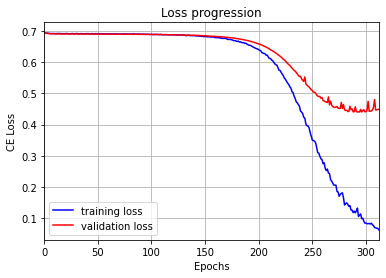

In [40]:
# plot training and validation loss
plt.plot(loss_train_his, label='training loss', color='blue')
plt.plot(loss_valid_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Loss progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.2 Zoom at the minimum CE loss in the validation loss curve

Epoch with minimum validation loss = 293


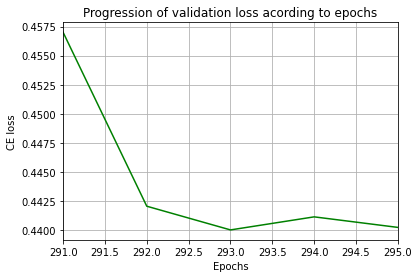

In [41]:
BEST_EPOCH = loss_valid_his.index(min(loss_valid_his)) + 1
print('Epoch with minimum validation loss =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), loss_valid_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

### 6.3 Accuracy 

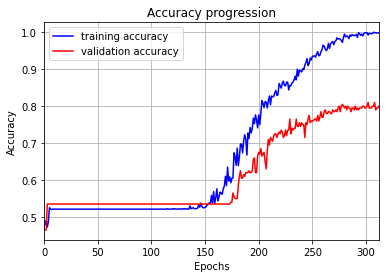

In [42]:
# plot training and validation accuracy
plt.plot(acc_train_his, label='training accuracy', color='blue')
plt.plot(acc_valid_his, label='validation accuracy', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

### 6.4 Print the final values of the main training monitoring variables:
- loss function final value:
- metrics final values:

In [43]:
print('last training loss = {0:.4f}'.format(loss_train_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_valid_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train_his[-1]))
print('last validation accuracy = {0:.4f}'.format(acc_valid_his[-1]))

last training loss = 0.0616
last validation loss = 0.4492
#-------------------------------------------------
last train accuracy = 0.9975
last validation accuracy = 0.8000


## 7. Metrics on test set

For this particular dataset, we will be using the validation set to calculate the performance metrics

In [44]:
# load model in CPU
model.to('cpu');
# evaluation mode
model.eval()

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=16461, out_features=600, bias=True)
  (layer2): Linear(in_features=600, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
# y_true
y_true = ds_valid[:][1]

In [0]:
# y_pred
score = 0.
y_logitos = model(ds_valid[:][0])
y_pred = torch.argmax(y_logitos, dim=1)

### 7.1 Accuracy

In [47]:
# accuracy
score += (y_true == y_pred).sum()
acc_test = score / len(ds_valid[:][0])
acc_test.item()

0.800000011920929

### 7.2 Confusion matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
#classes = enc.get_feature_names()
classes = ['negative', 'positive']

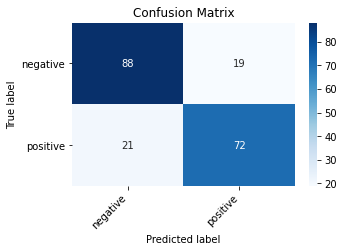

In [49]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

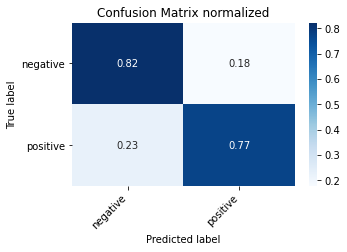

In [50]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Blues, fontsize=10, figsize = (5,3))

### 7.3 F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [52]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.7987117552334944
F1-score micro = 0.8000000000000002
F1-score weighted = 0.7998389694041868


### 7.4 Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [54]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.8
Precision score = 0.7992741203750378


### 7.5 Precision, Recall and F1-Score for each class

In [55]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       107
           1       0.79      0.77      0.78        93

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.80      0.80       200



## 8. Repeat training using GloVe Word Embeddings

In [0]:
TFIDF = False

In [0]:
if TFIDF:
    # datasets using TF-IDF
    ds_train = TensorDataset(X_train_tfidf, y_train)
    ds_valid = TensorDataset(X_valid_tfidf, y_valid)
else:
    # dataset using Word Embeddings
    ds_train = TensorDataset(X_train_emb, y_train)
    ds_valid = TensorDataset(X_valid_emb, y_valid)

### 8.1 Data loader

In [0]:
BATCH_SIZE = 100
#-------------------------------------------------
# training data loader
dl_train = torch.utils.data.DataLoader(
            dataset=ds_train, 
            drop_last = False,
            shuffle = True,
            batch_size = BATCH_SIZE)
#-------------------------------------------------
# validation data loader
dl_valid =  torch.utils.data.DataLoader(
            dataset = ds_valid,
            drop_last = False,
            shuffle = False,
            batch_size = BATCH_SIZE)

### 8.2 Network instantiation

In [59]:
model_emb = NN(glove_embedding.dim, layer1_neurons=500, layer2_neurons=100)
model_emb.to(device)

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=300, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=2, bias=True)
)

### 8.3 Network training

Training definitions

In [0]:
# Training parameters
EPOCH = 1000
LR = 0.01
PATIENCE = 10
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model_emb.parameters(), lr=LR)
#-------------------
best_valid_loss = 999_999.
train_samples = len(ds_train)
valid_samples = len(ds_valid)
#-------------------
trainer = TrainingLoop(device, model_emb, dl_train, loss_func, opt)
validator = ValidatingLoop(device, model_emb, dl_valid, loss_func)
#-------------------
# loss history
loss_train_his = []
loss_valid_his = []
acc_train_his = []
acc_valid_his = []

Training loop

In [61]:
for epoch in range(EPOCH):
    # training
    his_train = trainer()
    loss_train_his.append(his_train[0])
    acc_train_his.append(his_train[1] / train_samples)
    #-------------------
    # validating
    his_valid = validator()
    loss_valid_his.append(his_valid[0])
    acc_valid_his.append(his_valid[1] / valid_samples)
    #-------------------------------------------------
    # early stopping: check if new validation accuracy occurred
    if loss_valid_his[-1] < best_valid_loss:
        # print('New best loss in validation set!', end=' ')
        best_valid_loss = loss_valid_his[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter == PATIENCE:
            print('Early stopping:', PATIENCE, 'iterations without validation loss improve')
            break
    #-------------------------------------------------
    if not (epoch % 10):
        print('epoch =', epoch, end='; ')
        print('loss_train = {0:.4f}'.format(loss_train_his[-1]), end='; ')
        print('loss_val = {0:.4f}'.format(loss_valid_his[-1]), end='; ')
        print('acc_train = {0:.4f}'.format(acc_train_his[-1]), end='; ')
        print('acc_val = {0:.4f}'.format(acc_valid_his[-1]), end='\n')

epoch = 0; loss_train = 0.6919; loss_val = 0.6908; acc_train = 0.5225; acc_val = 0.5350
epoch = 10; loss_train = 0.6925; loss_val = 0.6905; acc_train = 0.5225; acc_val = 0.5350
epoch = 20; loss_train = 0.6916; loss_val = 0.6902; acc_train = 0.5225; acc_val = 0.5350
epoch = 30; loss_train = 0.6914; loss_val = 0.6898; acc_train = 0.5188; acc_val = 0.5350
epoch = 40; loss_train = 0.6918; loss_val = 0.6894; acc_train = 0.5250; acc_val = 0.5350
epoch = 50; loss_train = 0.6903; loss_val = 0.6890; acc_train = 0.5250; acc_val = 0.5350
epoch = 60; loss_train = 0.6898; loss_val = 0.6885; acc_train = 0.5262; acc_val = 0.5350
epoch = 70; loss_train = 0.6888; loss_val = 0.6879; acc_train = 0.5300; acc_val = 0.5350
epoch = 80; loss_train = 0.6897; loss_val = 0.6874; acc_train = 0.5337; acc_val = 0.5350
epoch = 90; loss_train = 0.6885; loss_val = 0.6868; acc_train = 0.5350; acc_val = 0.5350
epoch = 100; loss_train = 0.6891; loss_val = 0.6862; acc_train = 0.5288; acc_val = 0.5350
epoch = 110; loss_tra

### 8.4 Training evaluation

Training Loss

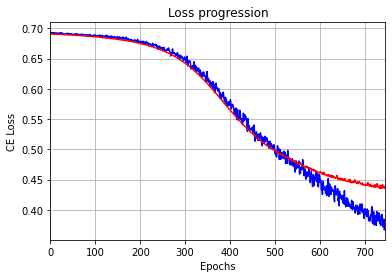

In [62]:
# plot training and validation loss
plt.plot(loss_train_his, label='training loss', color='blue')
plt.plot(loss_valid_his, label='validation loss', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('CE Loss')
# title
plt.title('Loss progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
#plt.legend() # add legend
plt.show()

Zoom at the minimum of CE loss curve

Epoch with minimum validation loss = 737


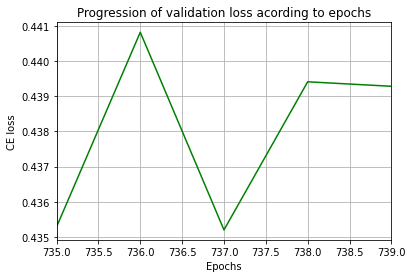

In [63]:
BEST_EPOCH = loss_valid_his.index(min(loss_valid_his)) + 1
print('Epoch with minimum validation loss =', BEST_EPOCH)
#-------------------------------------------------
# plots
plt.plot(range(max(1,BEST_EPOCH-2),min(EPOCH,BEST_EPOCH+3)), loss_valid_his[max(1,BEST_EPOCH-3):min(EPOCH-1,BEST_EPOCH+2)], 'green')
plt.xlabel('Epochs')
plt.ylabel('CE loss')
plt.autoscale(axis='x', tight=True)
plt.title('Progression of validation loss acording to epochs')
plt.grid(True)
plt.show()

Accuracy

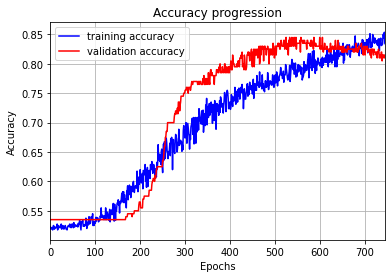

In [65]:
# plot training and validation accuracy
plt.plot(acc_train_his, label='training accuracy', color='blue')
plt.plot(acc_valid_his, label='validation accuracy', color='red')
#-------------------------------------------------
# axis label
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# title
plt.title('Accuracy progression')
#-------------------------------------------------
plt.autoscale(axis='x', tight=True) # axis adjust
plt.grid(True) # add grid
plt.legend() # add legend
plt.show()

Print the final values of the main training monitoring variables:

In [66]:
print('last training loss = {0:.4f}'.format(loss_train_his[-1]))
print('last validation loss = {0:.4f}'.format(loss_valid_his[-1]))
print('#-------------------------------------------------')
print('last train accuracy = {0:.4f}'.format(acc_train_his[-1]))
print('last validation accuracy = {0:.4f}'.format(acc_valid_his[-1]))

last training loss = 0.3834
last validation loss = 0.4358
#-------------------------------------------------
last train accuracy = 0.8337
last validation accuracy = 0.8100


### 8.5. Metrics on test set

For this particular dataset, we will be using the validation set to calculate the performance metrics

In [67]:
# load model in CPU
model_emb.to('cpu');
# evaluation mode
model_emb.eval()

NN(
  (dropout): Dropout(p=0.5, inplace=False)
  (layer1): Linear(in_features=300, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=2, bias=True)
)

In [0]:
# y_true
y_true = ds_valid[:][1]

In [0]:
# y_pred
score = 0.
y_logitos = model_emb(ds_valid[:][0])
y_pred = torch.argmax(y_logitos, dim=1)

Accuracy

In [70]:
# accuracy
score += (y_true == y_pred).sum()
acc_test = score / len(ds_valid[:][0])
acc_test.item()

0.8100000023841858

Confusion matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
#classes = enc.get_feature_names()
classes = ['negative', 'positive']

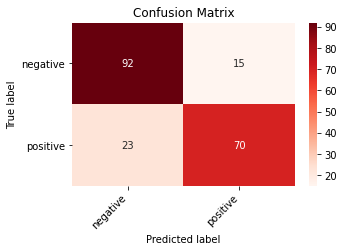

In [72]:
# CM raw
cm_raw = print_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=False, cmap=plt.cm.Reds, fontsize=10, figsize = (5,3))

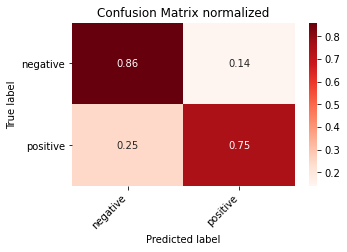

In [73]:
# CM normalized
cm_norm = print_confusion_matrix(cm, classes, title='Confusion Matrix normalized', normalize=True, cmap=plt.cm.Reds, fontsize=10, figsize = (5,3))

F1-score (macro, micro and weighted)

In [0]:
macro = f1_score(y_true, y_pred, average='macro')
micro = f1_score(y_true, y_pred, average='micro')
weighted = f1_score(y_true, y_pred, average='weighted')

In [75]:
print('F1-score macro =', macro)
print('F1-score micro =', micro)
print('F1-score weighted =', weighted)

F1-score macro = 0.8076728413807066
F1-score micro = 0.81
F1-score weighted = 0.8091537605020753


Accuracy and Precision

In [0]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')

In [77]:
print('Accuracy score = ', acc, sep='')
print('Precision score = ', prec, sep='')

Accuracy score = 0.81
Precision score = 0.8117647058823529


Precision, Recall and F1-Score for each class

In [78]:
from sklearn.metrics import classification_report as cr
print(cr(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       107
           1       0.82      0.75      0.79        93

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



## 9. Number of parameters

### 9.1 TF-IDF

In [79]:
nparam(model, verbose=True)

layer 0: layer1.weight; parameters: 9876600
layer 1: layer1.bias; parameters: 600
layer 2: layer2.weight; parameters: 60000
layer 3: layer2.bias; parameters: 100
layer 4: layer3.weight; parameters: 200
layer 5: layer3.bias; parameters: 2
total parameters =  9937502


### 9.2 GloVe word embeddings

In [80]:
nparam(model_emb, verbose=True)

layer 0: layer1.weight; parameters: 150000
layer 1: layer1.bias; parameters: 500
layer 2: layer2.weight; parameters: 50000
layer 3: layer2.bias; parameters: 100
layer 4: layer3.weight; parameters: 200
layer 5: layer3.bias; parameters: 2
total parameters =  200802


## End of the notebook